In [4]:
import numpy as np
import scipy
import pandas as pd
import math
import random
import sklearn
from nltk.corpus import stopwords
from scipy.sparse import csr_matrix
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse.linalg import svds
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt


In [5]:
interactions_df = pd.read_csv('/content/drive/MyDrive/df2/df3.csv')
articles_df = pd.read_csv('/content/drive/MyDrive/df2/articlesdata.csv')
interactions_df.head(10)

,usr_id,variable,contentid,eventType
0,24,43,130027,VIEW
1,18,42,30061,FOLLOW
2,14,34,130012,BOOKMARK
3,14,44,30068,VIEW
4,3,52,30074,VIEW
5,13,25,8005,VIEW
6,6,29,40023,VIEW
7,18,15,110018,VIEW
8,16,11,110014,VIEW
9,2,3,5008,BOOKMARK


In [6]:
articles_df.head()


,head_line,description,category,contentid,link,img
0,West Indies won 2016 World T20 after final ove...,"Needing 19 runs in the last over, Carlos Brath...",sports,1001,/en/news/west-indies-won-2016-world-t20-after-...,https://static.inshorts.com/inshorts/images/v1...
1,All 11 New Zealand players were once awarded '...,The entire New Zealand team was once given the...,sports,1002,/en/news/all-11-new-zealand-players-were-once-...,https://static.inshorts.com/inshorts/images/v1...
2,10 Wankhede ground staff test COVID positive; ...,Ten ground staff of Mumbai's Wankhede Stadium ...,sports,1003,/en/news/10-wankhede-ground-staff-test-covid-p...,https://static.inshorts.com/inshorts/images/v1...
3,"I am obsessed with Rishabh Pant, he is an abso...",BCCI President Sourav Ganguly has said that he...,sports,1004,/en/news/i-am-obsessed-with-rishabh-pant-he-is...,https://static.inshorts.com/inshorts/images/v1...
4,Must be missing TikTok: Rohit trolls Warner as...,Mumbai Indians captain Rohit Sharma trolled Su...,sports,1005,/en/news/must-be-missing-tiktok-rohit-trolls-w...,https://static.inshorts.com/inshorts/images/v1...


In [7]:
event_type_strength = {
   'VIEW': 1.0,
   'LIKE': 2.0, 
   'BOOKMARK': 2.5, 
   'FOLLOW': 3.0,
   'COMMENT CREATED': 4.0,  
}

interactions_df['eventStrength'] = interactions_df['eventType'].apply(lambda x: event_type_strength[x])

In [8]:
users_interactions_count_df = interactions_df.groupby(['usr_id', 'contentid']).size().groupby('usr_id').size()
print('users: %d' % len(users_interactions_count_df))
users_with_enough_interactions_df = users_interactions_count_df[users_interactions_count_df >= 5].reset_index()[['usr_id']]
print('users with at least 5 interactions: %d' % len(users_with_enough_interactions_df))

users: 25
users with at least 5 interactions: 25


In [9]:
users_interactions_count_df

usr_id
0     55
1     50
2     53
3     54
4     52
5     48
6     49
7     52
8     50
9     54
10    48
11    50
12    51
13    53
14    47
15    56
16    48
17    52
18    47
19    55
20    48
21    47
22    48
23    49
24    53
dtype: int64

In [10]:
print('# of interactions: %d' % len(interactions_df))
interactions_from_selected_users_df = interactions_df.merge(users_with_enough_interactions_df, 
               how = 'right',
               left_on = 'usr_id',
               right_on = 'usr_id')
print('# of interactions from users with at least 5 interactions: %d' % len(interactions_from_selected_users_df))

# of interactions: 1269
# of interactions from users with at least 5 interactions: 1269


In [11]:
interactions_from_selected_users_df

,usr_id,variable,contentid,eventType,eventStrength
0,0,5,80023,BOOKMARK,2.5
1,0,12,100020,LIKE,2.0
2,0,27,40012,VIEW,1.0
3,0,53,70012,VIEW,1.0
4,0,51,60022,FOLLOW,3.0
...,...,...,...,...,...
1264,24,45,1004,LIKE,2.0
1265,24,32,10073,VIEW,1.0
1266,24,28,20044,BOOKMARK,2.5
1267,24,13,20015,VIEW,1.0


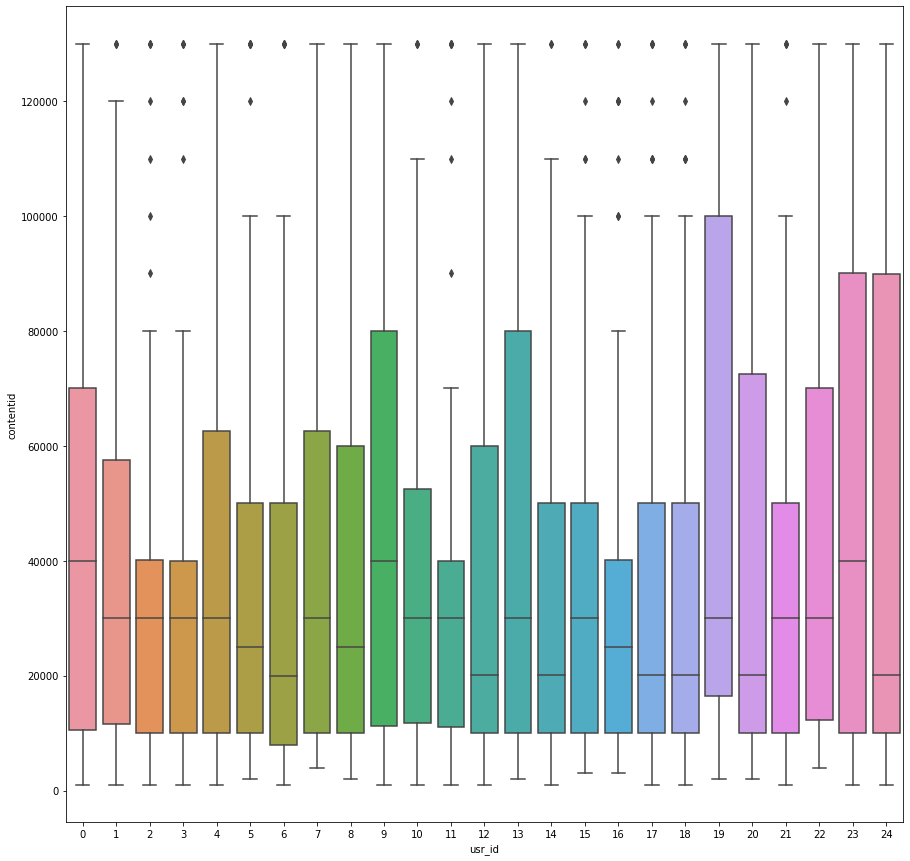

In [12]:
import seaborn as sns

f, ax = plt.subplots(figsize=(15, 15))
# ax.set_xscale("log")

sns.boxplot(x="usr_id", y="contentid",
            data=interactions_from_selected_users_df)
# sns.despine(offset=10, trim=True)


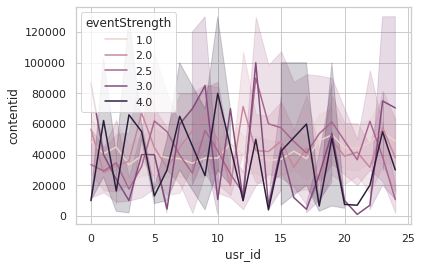

In [13]:
sns.set_theme(style="whitegrid")
# f, ax = plt.subplots(figsize=(15, 10)

sns.lineplot(x="usr_id", y="contentid",
             hue="eventStrength",  
             data=interactions_from_selected_users_df)



# g = sns.catplot(
#     data=articles_df, kind="bar",
#     x="category", y="contentid")


In [14]:
def smooth_user_preference(x):
    return math.log(1+x, 2)
    
interactions_full_df = interactions_from_selected_users_df \
                    .groupby(['usr_id', 'contentid'])['eventStrength'].sum() \
                    .apply(smooth_user_preference).reset_index()
print('# of unique user/item interactions: %d' % len(interactions_full_df))
interactions_full_df.head(10)

# of unique user/item interactions: 1269


,usr_id,contentid,eventStrength
0,0,1004,1.807355
1,0,2003,1.000000
2,0,3001,1.000000
3,0,3004,1.584963
4,0,3007,1.000000
5,0,5004,1.000000
6,0,10008,2.321928
7,0,10012,2.321928
8,0,10022,2.321928
9,0,10024,1.000000


# Evaluvation


In [15]:
def smooth_user_preference(x):
    return math.log(1+x, 2)
    
interactions_full_df = interactions_from_selected_users_df \
                    .groupby(['usr_id', 'contentid'])['eventStrength'].sum() \
                    .apply(smooth_user_preference).reset_index()
print('# of unique user/item interactions: %d' % len(interactions_full_df))
interactions_full_df.head(10)

# of unique user/item interactions: 1269


,usr_id,contentid,eventStrength
0,0,1004,1.807355
1,0,2003,1.000000
2,0,3001,1.000000
3,0,3004,1.584963
4,0,3007,1.000000
5,0,5004,1.000000
6,0,10008,2.321928
7,0,10012,2.321928
8,0,10022,2.321928
9,0,10024,1.000000


In [16]:
interactions_train_df, interactions_test_df = train_test_split(interactions_full_df,
                                   stratify=interactions_full_df['usr_id'], 
                                   test_size=0.20,
                                   random_state=42)

print('# interactions on Train set: %d' % len(interactions_train_df))
print('# interactions on Test set: %d' % len(interactions_test_df))

# interactions on Train set: 1015
# interactions on Test set: 254


In [17]:
#Indexing by usr_id to speed up the searches during evaluation
interactions_full_indexed_df = interactions_full_df.set_index('usr_id')
interactions_train_indexed_df = interactions_train_df.set_index('usr_id')
interactions_test_indexed_df = interactions_test_df.set_index('usr_id')

In [18]:
def get_items_interacted(usr_id, interactions_df):
    # Get the user's data and merge in the movie information.
    interacted_items = interactions_df.loc[usr_id]['contentid']
    return set(interacted_items if type(interacted_items) == pd.Series else [interacted_items])

In [19]:
#Top-N accuracy metrics consts
EVAL_RANDOM_SAMPLE_NON_INTERACTED_ITEMS = 100

class ModelEvaluator:


    def get_not_interacted_items_sample(self, usr_id, sample_size, seed=42):
        interacted_items = get_items_interacted(usr_id, interactions_full_indexed_df)
        all_items = set(articles_df['contentid'])
        non_interacted_items = all_items - interacted_items

        random.seed(seed)
        non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
        return set(non_interacted_items_sample)

    def _verify_hit_top_n(self, item_id, recommended_items, topn):        
            try:
                index = next(i for i, c in enumerate(recommended_items) if c == item_id)
            except:
                index = -1
            hit = int(index in range(0, topn))
            return hit, index

    def evaluate_model_for_user(self, model, usr_id):
        #Getting the items in test set
        interacted_values_testset = interactions_test_indexed_df.loc[usr_id]
        if type(interacted_values_testset['contentid']) == pd.Series:
            person_interacted_items_testset = set(interacted_values_testset['contentid'])
        else:
            person_interacted_items_testset = set([int(interacted_values_testset['contentid'])])  
        interacted_items_count_testset = len(person_interacted_items_testset) 

        #Getting a ranked recommendation list from a model for a given user
        person_recs_df = model.recommend_items(usr_id, 
                                               items_to_ignore=get_items_interacted(usr_id, 
                                                                                    interactions_train_indexed_df), 
                                               topn=10000000000)

        hits_at_5_count = 0
        hits_at_10_count = 0
        #For each item the user has interacted in test set
        for item_id in person_interacted_items_testset:
            #Getting a random sample (100) items the user has not interacted 
            #(to represent items that are assumed to be no relevant to the user)
            non_interacted_items_sample = self.get_not_interacted_items_sample(usr_id, 
                                                                          sample_size=EVAL_RANDOM_SAMPLE_NON_INTERACTED_ITEMS, 
                                                                          seed=item_id%(2**32))

            #Combining the current interacted item with the 100 random items
            items_to_filter_recs = non_interacted_items_sample.union(set([item_id]))

            #Filtering only recommendations that are either the interacted item or from a random sample of 100 non-interacted items
            valid_recs_df = person_recs_df[person_recs_df['contentid'].isin(items_to_filter_recs)]                    
            valid_recs = valid_recs_df['contentid'].values
            #Verifying if the current interacted item is among the Top-N recommended items
            hit_at_5, index_at_5 = self._verify_hit_top_n(item_id, valid_recs, 5)
            hits_at_5_count += hit_at_5
            hit_at_10, index_at_10 = self._verify_hit_top_n(item_id, valid_recs, 10)
            hits_at_10_count += hit_at_10

        #Recall is the rate of the interacted items that are ranked among the Top-N recommended items, 
        #when mixed with a set of non-relevant items
        recall_at_5 = hits_at_5_count / float(interacted_items_count_testset)
        recall_at_10 = hits_at_10_count / float(interacted_items_count_testset)

        person_metrics = {'hits@5_count':hits_at_5_count, 
                          'hits@10_count':hits_at_10_count, 
                          'interacted_count': interacted_items_count_testset,
                          'recall@5': recall_at_5,
                          'recall@10': recall_at_10}
        return person_metrics

    def evaluate_model(self, model):
        #print('Running evaluation for users')
        people_metrics = []
        for idx, usr_id in enumerate(list(interactions_test_indexed_df.index.unique().values)):
            #if idx % 100 == 0 and idx > 0:
            #    print('%d users processed' % idx)
            person_metrics = self.evaluate_model_for_user(model, usr_id)  
            person_metrics['_usr_id'] = usr_id
            people_metrics.append(person_metrics)
        print('%d users processed' % idx)

        detailed_results_df = pd.DataFrame(people_metrics) \
                            .sort_values('interacted_count', ascending=False)
        
        global_recall_at_5 = detailed_results_df['hits@5_count'].sum() / float(detailed_results_df['interacted_count'].sum())
        global_recall_at_10 = detailed_results_df['hits@10_count'].sum() / float(detailed_results_df['interacted_count'].sum())
        
        global_metrics = {'modelName': model.get_model_name(),
                          'recall@5': global_recall_at_5,
                          'recall@10': global_recall_at_10}    
        return global_metrics, detailed_results_df
    
model_evaluator = ModelEvaluator()    

# Popularity model

In [20]:
#Computes the most popular items
item_popularity_df = interactions_full_df.groupby('contentid')['eventStrength'].sum().sort_values(ascending=False).reset_index()
item_popularity_df.head(10)

,contentid,eventStrength
0,5008,10.521600
1,2001,10.199672
2,3002,9.621136
3,10017,9.228819
4,10074,8.784635
5,40061,8.562242
6,30047,8.521600
7,110010,8.491853
8,130033,7.977280
9,10069,7.906891


In [21]:
class PopularityRecommender:
    
    MODEL_NAME = 'Popularity'
    
    def __init__(self, popularity_df, items_df=None):
        self.popularity_df = popularity_df
        self.items_df = items_df
        
    def get_model_name(self):
        return self.MODEL_NAME
        
    def recommend_items(self, user_id, items_to_ignore=[], topn=10, verbose=False):
        # Recommend the more popular items that the user hasn't seen yet.
        recommendations_df = self.popularity_df[~self.popularity_df['contentid'].isin(items_to_ignore)] \
                               .sort_values('eventStrength', ascending = False) \
                               .head(topn)

        if verbose:
            if self.items_df is None:
                raise Exception('"items_df" is required in verbose mode')

            recommendations_df = recommendations_df.merge(self.items_df, how = 'left', 
                                                          left_on = 'contentid', 
                                                          right_on = 'contentid')[['eventStrength', 'contentid', 'head_line', 'link']]


        recommendations_df.head()

        return recommendations_df
    
popularity_model = PopularityRecommender(item_popularity_df, articles_df)

In [22]:
popularity_model.recommend_items(20, topn=20, verbose=True)


,eventStrength,contentid,head_line,link
0,10.521600,5008,"BJP understands Dalits' views, it made a Dalit...",/en/news/bjp-understands-dalits-views-it-made-...
1,10.199672,2001,"World was on standstill, you never took a day ...",/en/news/world-was-on-standstill-you-never-too...
2,9.621136,3002,"Mumbai airport imposes ₹1,000 fine for violati...",/en/news/mumbai-airport-imposes-₹1000-fine-for...
3,9.228819,10017,ATP updates protocols to add benefits for taki...,/en/news/atp-updates-protocols-to-add-benefits...
4,8.784635,10074,India vs England: Nothing wrong with our metho...,/sports/cricket/england-in-india/india-vs-engl...
5,8.562242,40061,Jury in George Floyd murder trial shown harrow...,/world/us/jury-in-george-floyd-murder-trial-sh...
6,8.521600,30047,"Can't rule out lockdown, says Maha CM as cases...",/city/mumbai/cant-rule-out-lockdown-says-mahar...
7,8.491853,110010,Earth safe for over 100 yrs from asteroid Apop...,/en/news/earth-safe-for-over-100-yrs-from-aste...
8,7.977280,130033,What is Traffic Vada Pav?,/life-style/food-news/what-is-traffic-vada-pav...
9,7.906891,10069,"One year late, virus-delayed Tokyo Olympics to...",/sports/tokyo-olympics/one-year-late-virus-del...


In [23]:
# popularity_model_df.head(1)

In [24]:
# popularity_model_df
# mergedStuff = pd.merge(articles_df,popularity_model_df, on=['contentid'], how='inner')
# mergedStuff.shape

In [25]:
# preferance = mergedStuff.sort_values(['category','eventStrength'], ascending=False)


In [26]:


# compression_opts = dict(method='zip',
#                         archive_name='preferance.csv')  
# preferance.to_csv('preferance.zip', index=False,
#           compression=compression_opts)  

In [27]:
print('Evaluating Popularity recommendation model...')
pop_global_metrics, pop_detailed_results_df = model_evaluator.evaluate_model(popularity_model)
print('\nGlobal metrics:\n%s' % pop_global_metrics)
pop_detailed_results_df.head(10)

Evaluating Popularity recommendation model...
24 users processed

Global metrics:
{'modelName': 'Popularity', 'recall@5': 0.0984251968503937, 'recall@10': 0.19291338582677164}


,hits@5_count,hits@10_count,interacted_count,recall@5,recall@10,_usr_id
10,1,1,11,0.090909,0.090909,9
2,1,1,11,0.090909,0.090909,15
3,1,2,11,0.090909,0.181818,24
4,1,5,11,0.090909,0.454545,19
19,3,3,11,0.272727,0.272727,13
17,0,2,11,0.000000,0.181818,2
23,0,0,11,0.000000,0.000000,3
14,1,1,11,0.090909,0.090909,0
1,2,6,10,0.200000,0.600000,5
18,0,0,10,0.000000,0.000000,1


# Content-Based Filtering model

Content-based filtering approaches leverage description or attributes from items the user has interacted to recommend similar items. It depends only on the user previous choices, making this method robust to avoid the *cold-start* problem.
For textual items, like articles, news and books, it is simple to use the raw text to build item profiles and user profiles.  

In [28]:
articles_df.isnull().sum()

head_line      0
description    0
category       0
contentid      0
link           0
img            0
dtype: int64

In [29]:
articles_df[articles_df['description'].isnull()].index.tolist()

[]

## TfidfVectorizer

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [30]:
stopwords_list = stopwords.words('english') 

vectorizer = TfidfVectorizer(analyzer='word',
                     ngram_range=(1, 2),
                     min_df=0.003,
                     stop_words=stopwords_list)

item_ids = articles_df['contentid'].tolist()
tfidf_matrix = vectorizer.fit_transform(articles_df['head_line'] + "" + articles_df['description'])
tfidf_feature_names = vectorizer.get_feature_names()
tfidf_matrix

<545x4742 sparse matrix of type '<class 'numpy.float64'>'
	with 18514 stored elements in Compressed Sparse Row format>

To model the user profile, we take all the item profiles the user has interacted and average them. The average is weighted by the interaction strength, in other words, the articles the user has interacted the most (eg. liked or commented) will have a higher strength in the final user profile.   

In [31]:
def get_item_profile(item_id):
    idx = item_ids.index(item_id)
    item_profile = tfidf_matrix[idx:idx+1]
    return item_profile

def get_item_profiles(ids):
    item_profiles_list = [get_item_profile(x) for x in ids]
    item_profiles = scipy.sparse.vstack(item_profiles_list)
    return item_profiles

def build_users_profile(usr_id, interactions_indexed_df):
    interactions_person_df = interactions_indexed_df.loc[usr_id]
    user_item_profiles = get_item_profiles(interactions_person_df['contentid'])
    
    user_item_strengths = np.array(interactions_person_df['eventStrength']).reshape(-1,1)
    #Weighted average of item profiles by the interactions strength
    user_item_strengths_weighted_avg = np.sum(user_item_profiles.multiply(user_item_strengths), axis=0) / np.sum(user_item_strengths)
    user_profile_norm = sklearn.preprocessing.normalize(user_item_strengths_weighted_avg)
    return user_profile_norm

def build_users_profiles(): 
    interactions_indexed_df = interactions_train_df[interactions_train_df['contentid'] \
                                                   .isin(articles_df['contentid'])].set_index('usr_id')
    user_profiles = {}
    for usr_id in interactions_indexed_df.index.unique():
        user_profiles[usr_id] = build_users_profile(usr_id, interactions_indexed_df)
    return user_profiles

In [32]:
user_profiles = build_users_profiles()
len(user_profiles)

25

In [33]:
user_profiles

{0: array([[0.01068507, 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ]]),
 1: array([[0.0191202 , 0.        , 0.        , ..., 0.        , 0.        ,
         0.01332782]]),
 2: array([[0.00858365, 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ]]),
 3: array([[0.08160866, 0.        , 0.03840965, ..., 0.        , 0.        ,
         0.01317549]]),
 4: array([[0.06311112, 0.        , 0.02647148, ..., 0.        , 0.        ,
         0.        ]]),
 5: array([[0., 0., 0., ..., 0., 0., 0.]]),
 6: array([[0.04404668, 0.        , 0.02557383, ..., 0.        , 0.0474172 ,
         0.03296448]]),
 7: array([[0.01015145, 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ]]),
 8: array([[0.01101137, 0.        , 0.        , ..., 0.        , 0.        ,
         0.04479119]]),
 9: array([[0., 0., 0., ..., 0., 0., 0.]]),
 10: array([[0.04584623, 0.        , 0.02497306, ..., 0.        , 0.        ,
         0.        ]]),
 1

In [34]:
myprofile = user_profiles[24]
print(myprofile.shape)
pd.DataFrame(sorted(zip(tfidf_feature_names, 
                        user_profiles[24].flatten().tolist()), key=lambda x: -x[1])[:20],
             columns=['token', 'relevance'])

(1, 4742)


,token,relevance
0,police,0.156968
1,us,0.146634
2,gold,0.140164
3,said,0.135874
4,man,0.123287
5,world,0.118332
6,house,0.111917
7,time,0.108084
8,actor,0.107917
9,arrested,0.106382


In [35]:
class ContentBasedRecommender:
    
    MODEL_NAME = 'Content-Based'
    
    def __init__(self, items_df=None):
        self.item_ids = item_ids
        self.items_df = items_df
        
    def get_model_name(self):
        return self.MODEL_NAME
        
    def _get_similar_items_to_user_profile(self, usr_id, topn=1000):
        #Computes the cosine similarity between the user profile and all item profiles
        cosine_similarities = cosine_similarity(user_profiles[usr_id], tfidf_matrix)
        #Gets the top similar items
        similar_indices = cosine_similarities.argsort().flatten()[-topn:]
        #Sort the similar items by similarity
        similar_items = sorted([(item_ids[i], cosine_similarities[0,i]) for i in similar_indices], key=lambda x: -x[1])
        return similar_items
        
    def recommend_items(self, user_id, items_to_ignore=[], topn=10, verbose=False):
        similar_items = self._get_similar_items_to_user_profile(user_id)
        #Ignores items the user has already interacted
        similar_items_filtered = list(filter(lambda x: x[0] not in items_to_ignore, similar_items))
        
        recommendations_df = pd.DataFrame(similar_items_filtered, columns=['contentid', 'recStrength']) \
                                    .head(topn)

        if verbose:
            if self.items_df is None:
                raise Exception('"items_df" is required in verbose mode')

            recommendations_df = recommendations_df.merge(self.items_df, how = 'left', 
                                                          left_on = 'contentid', 
                                                          right_on = 'contentid')[['recStrength', 'contentid', 'head_line', 'link']]


        return recommendations_df
    
content_based_recommender_model = ContentBasedRecommender(articles_df)

With personalized recommendations of content-based filtering model, we have a **Recall@5** to about **0.0708**, which means that about **16%** of interacted items in test set were ranked by this model among the top-5 items (from lists with 100 random items).
And **Recall@10** was **0.133**.
The lower performance of the Content-Based model compared to the Popularity model may indicate that users are not that fixed in content very similar to their previous reads.

In [36]:
print('Evaluating Content-Based Filtering model...')
cb_global_metrics, cb_detailed_results_df = model_evaluator.evaluate_model(content_based_recommender_model)
print('\nGlobal metrics:\n%s' % cb_global_metrics)
cb_detailed_results_df.head(10)

Evaluating Content-Based Filtering model...
24 users processed

Global metrics:
{'modelName': 'Content-Based', 'recall@5': 0.07086614173228346, 'recall@10': 0.13385826771653545}


,hits@5_count,hits@10_count,interacted_count,recall@5,recall@10,_usr_id
10,1,1,11,0.090909,0.090909,9
2,1,2,11,0.090909,0.181818,15
3,1,2,11,0.090909,0.181818,24
4,2,2,11,0.181818,0.181818,19
19,1,1,11,0.090909,0.090909,13
17,0,1,11,0.000000,0.090909,2
23,0,0,11,0.000000,0.000000,3
14,0,0,11,0.000000,0.000000,0
1,1,3,10,0.100000,0.300000,5
18,0,0,10,0.000000,0.000000,1


In [58]:
popularity_model.recommend_items(23, topn=10, verbose=True)


,eventStrength,contentid,head_line,link
0,10.521600,5008,"BJP understands Dalits' views, it made a Dalit...",/en/news/bjp-understands-dalits-views-it-made-...
1,10.199672,2001,"World was on standstill, you never took a day ...",/en/news/world-was-on-standstill-you-never-too...
2,9.621136,3002,"Mumbai airport imposes ₹1,000 fine for violati...",/en/news/mumbai-airport-imposes-₹1000-fine-for...
3,9.228819,10017,ATP updates protocols to add benefits for taki...,/en/news/atp-updates-protocols-to-add-benefits...
4,8.784635,10074,India vs England: Nothing wrong with our metho...,/sports/cricket/england-in-india/india-vs-engl...
5,8.562242,40061,Jury in George Floyd murder trial shown harrow...,/world/us/jury-in-george-floyd-murder-trial-sh...
6,8.521600,30047,"Can't rule out lockdown, says Maha CM as cases...",/city/mumbai/cant-rule-out-lockdown-says-mahar...
7,8.491853,110010,Earth safe for over 100 yrs from asteroid Apop...,/en/news/earth-safe-for-over-100-yrs-from-aste...
8,7.977280,130033,What is Traffic Vada Pav?,/life-style/food-news/what-is-traffic-vada-pav...
9,7.906891,10069,"One year late, virus-delayed Tokyo Olympics to...",/sports/tokyo-olympics/one-year-late-virus-del...


# Collaborative Filtering model

Collaborative Filtering (CF) has two main implementation strategies:  
- **Memory-based**: This approach uses the memory of previous users interactions to compute users similarities based on items they've interacted (user-based approach) or compute items similarities based on the users that have interacted with them (item-based approach).  
A typical example of this approach is User Neighbourhood-based CF, in which the top-N similar users (usually computed using Pearson correlation) for a user are selected and used to recommend items those similar users liked, but the current user have not interacted yet. This approach is very simple to implement, but usually do not scale well for many users. 

## Matrix Factorization

One advantage of using this approach is that instead of having a high dimensional matrix containing abundant number of missing values we will be dealing with a much smaller matrix in lower-dimensional space.  
A reduced presentation could be utilized for either user-based or item-based neighborhood algorithms that are presented in the previous section. There are several advantages with this paradigm. It handles the sparsity of the original matrix better than memory based ones. Also comparing similarity on the resulting matrix is much more scalable especially in dealing with large sparse datasets.  

An important decision is the number of factors to factor the user-item matrix. The higher the number of factors, the more precise is the factorization in the original matrix reconstructions. Therefore, if the model is allowed to  memorize too much details of the original matrix, it may not generalize well for data it was not trained on. Reducing the number of factors increases the model generalization.

In [37]:
#Creating a sparse pivot table with users in rows and items in columns
users_items_pivot_matrix_df = interactions_train_df.pivot(index='usr_id', 
                                                          columns='contentid', 
                                                          values='eventStrength').fillna(0)

users_items_pivot_matrix_df.head(10)

contentid,1001,1002,1003,1004,1006,1007,1008,1009,2001,2002,2004,2005,2008,3001,3002,3003,3004,3006,3007,3008,3009,4001,4002,4003,4004,4005,4006,4007,4008,5001,5002,5003,5004,5005,5006,5007,5008,6001,6003,6005,...,120018,120019,120020,120021,120023,130010,130012,130013,130014,130015,130016,130017,130018,130019,130020,130021,130022,130023,130024,130025,130027,130028,130029,130030,130031,130032,130033,130035,130036,130037,130038,130039,130040,130041,130042,130043,130044,130045,130046,130047
usr_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,1.807355,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,1.584963,0.0,1.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,1.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.000000,1.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,1.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.000000,0.000000,0.0,1.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,2.321928,0.000000,0.0,0.0,0.000000,2.321928,0.000000,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.000000,1.584963,0.0,0.000000,0.0,1.584963,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,1.0,0.0,0.0,2.321928,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,1.807355,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,0.000000,0.0,0.0,0.000000,1.584963,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,1.0
3,0.0,0.0,1.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,2.321928,0.0,1.584963,0.0,0.000000,0.0,0.000000,0.0,0.0,1.0,0.000000,0.0,0.000000,0.000000,0.0,1.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,1.584963,0.000000,0.000000,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.000000,0.000000,0.0,1.807355,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,1.584963,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,1.000000,0.0,0.0,0.0,...,1.584963,0.0,0.0,0.0,0.0,0.000000,1.584963,0.0,1.584963,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,1.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,2.321928,0.0,0.0,1.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,1.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.584963,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,1.807355,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.000000,1.000000,0.0,0.000000,0.0,2.000000,0.0,0.000000,0.0,0.000000,0.0,1.584963,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,1.0,1.0,1.0,0.0,0.000000,1.0,0.000000,0.0,0.0,1.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,1.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,1.584963,0.000000,0.0

In [38]:
users_items_pivot_matrix = users_items_pivot_matrix_df.to_numpy()
users_items_pivot_matrix[:10]

array([[0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.]])

In [39]:
users_ids = list(users_items_pivot_matrix_df.index)
users_ids[:10]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [40]:
users_items_pivot_sparse_matrix = csr_matrix(users_items_pivot_matrix)
users_items_pivot_sparse_matrix

<25x464 sparse matrix of type '<class 'numpy.float64'>'
	with 1015 stored elements in Compressed Sparse Row format>

In [41]:
#The number of factors to factor the user-item matrix.
NUMBER_OF_FACTORS_MF = 15
#Performs matrix factorization of the original user item matrix
#U, sigma, Vt = svds(users_items_pivot_matrix, k = NUMBER_OF_FACTORS_MF)
U, sigma, Vt = svds(users_items_pivot_sparse_matrix, k = NUMBER_OF_FACTORS_MF)

In [42]:
U.shape

(25, 15)

In [43]:
Vt.shape

(15, 464)

In [44]:
sigma = np.diag(sigma)
sigma.shape

(15, 15)

After the factorization, we try to to reconstruct the original matrix by multiplying its factors. The resulting matrix is not sparse any more. It was generated predictions for items the user have not yet interaction, which we will exploit for recommendations.

In [45]:
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) 
all_user_predicted_ratings

array([[ 7.01521953e-02, -7.76675177e-02, -8.73316013e-03, ...,
         5.48380076e-02,  8.32242824e-02, -2.77936259e-02],
       [ 8.00445576e-01, -1.76927799e-01, -3.13152066e-02, ...,
         5.81275999e-02, -2.68448402e-01, -4.53389245e-02],
       [-8.66722671e-02,  1.07524090e-01, -3.34276812e-02, ...,
         2.70214337e-01,  9.22257402e-03,  7.83228975e-01],
       ...,
       [ 1.07319513e-01,  7.07259274e-02,  6.06765929e-05, ...,
         3.02472123e-01,  6.44047973e-01,  5.10280184e-03],
       [-3.74571493e-01,  2.15088785e-01,  6.45066668e-01, ...,
         1.05207332e+00,  1.14694119e-02,  3.40244453e-02],
       [ 3.61506729e-01, -3.12396472e-01,  2.15620811e-01, ...,
         1.38241177e+00,  2.14869158e-01,  4.08595443e-02]])

In [46]:
all_user_predicted_ratings_norm = (all_user_predicted_ratings - all_user_predicted_ratings.min()) / (all_user_predicted_ratings.max() - all_user_predicted_ratings.min())

In [47]:
#Converting the reconstructed matrix back to a Pandas dataframe
cf_preds_df = pd.DataFrame(all_user_predicted_ratings_norm, columns = users_items_pivot_matrix_df.columns, index=users_ids).transpose()
cf_preds_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24
contentid,,,,,,,,,,,,,,,,,,,,,,,,,
1001,0.219263,0.444982,0.170792,0.196205,0.337116,0.198432,0.191823,0.249278,0.049437,0.291823,0.160494,0.592775,0.142001,0.345985,0.516435,0.265758,0.248075,0.173338,0.133291,0.262000,0.196686,0.270982,0.230751,0.081808,0.309315
1002,0.173575,0.142896,0.230814,0.184716,0.278368,0.252953,0.239647,0.106649,0.181074,0.224867,0.263242,0.303076,0.244949,0.203911,0.216548,0.150951,0.198559,0.243122,0.096672,0.187844,0.349169,0.491318,0.219441,0.264060,0.101025
1003,0.194882,0.187902,0.187249,0.392862,0.185457,0.148684,0.170779,0.264694,0.306754,0.486265,0.279647,0.192705,0.262337,0.228062,0.194537,0.214310,0.160630,0.119880,0.201218,0.186066,0.263150,0.238031,0.197599,0.396958,0.264225
1004,0.746255,0.211557,0.220683,0.261508,0.198853,0.176975,0.241122,0.255043,0.228748,0.132641,0.149382,0.208807,0.325727,0.288234,0.268919,0.168882,0.264333,0.144869,0.178918,0.185469,0.181313,0.123054,0.319089,0.364099,0.422849
1006,0.173275,0.205593,0.610042,0.158039,0.216432,0.132068,0.396566,0.197870,0.284861,0.178026,0.127463,0.160504,0.274240,0.283956,0.185570,0.238392,0.235464,0.475260,0.263142,0.179780,0.236932,0.267722,0.297116,0.135800,0.194246


In [48]:
len(cf_preds_df.columns)

25

In [49]:
class CFRecommender:
    
    MODEL_NAME = 'Collaborative Filtering'
    
    def __init__(self, cf_predictions_df, items_df=None):
        self.cf_predictions_df = cf_predictions_df
        self.items_df = items_df
        
    def get_model_name(self):
        return self.MODEL_NAME
        
    def recommend_items(self, user_id, items_to_ignore=[], topn=10, verbose=False):
        # Get and sort the user's predictions
        sorted_user_predictions = self.cf_predictions_df[user_id].sort_values(ascending=False) \
                                    .reset_index().rename(columns={user_id: 'recStrength'})

        # Recommend the highest predicted rating movies that the user hasn't seen yet.
        recommendations_df = sorted_user_predictions[~sorted_user_predictions['contentid'].isin(items_to_ignore)] \
                               .sort_values('recStrength', ascending = False) \
                               .head(topn)

        if verbose:
            if self.items_df is None:
                raise Exception('"items_df" is required in verbose mode')

            recommendations_df = recommendations_df.merge(self.items_df, how = 'left', 
                                                          left_on = 'contentid', 
                                                          right_on = 'contentid')[['recStrength', 'contentid', 'head_line', 'link']]


        return recommendations_df
    
cf_recommender_model = CFRecommender(cf_preds_df, articles_df)

> Evaluating the Collaborative Filtering model (SVD matrix factorization), we observe that we got **Recall@5: 0.05** and **Recall@10: 0.09** values, much higher than Popularity model and Content-Based model.

In [50]:
print('Evaluating Collaborative Filtering (SVD Matrix Factorization) model...')
cf_global_metrics, cf_detailed_results_df = model_evaluator.evaluate_model(cf_recommender_model)
print('\nGlobal metrics:\n%s' % cf_global_metrics)
cf_detailed_results_df.head(10)

Evaluating Collaborative Filtering (SVD Matrix Factorization) model...
24 users processed

Global metrics:
{'modelName': 'Collaborative Filtering', 'recall@5': 0.051181102362204724, 'recall@10': 0.09448818897637795}


,hits@5_count,hits@10_count,interacted_count,recall@5,recall@10,_usr_id
10,0,0,11,0.000000,0.000000,9
2,0,0,11,0.000000,0.000000,15
3,0,0,11,0.000000,0.000000,24
4,1,2,11,0.090909,0.181818,19
19,0,0,11,0.000000,0.000000,13
17,0,1,11,0.000000,0.090909,2
23,1,1,11,0.090909,0.090909,3
14,1,1,11,0.090909,0.090909,0
1,2,2,10,0.200000,0.200000,5
18,0,0,10,0.000000,0.000000,1


# Hybrid Recommender

In [51]:
class HybridRecommender:
    
    MODEL_NAME = 'Hybrid'
    
    def __init__(self, cb_rec_model, cf_rec_model, items_df, cb_ensemble_weight=1.0, cf_ensemble_weight=1.0):
        self.cb_rec_model = cb_rec_model
        self.cf_rec_model = cf_rec_model
        self.cb_ensemble_weight = cb_ensemble_weight
        self.cf_ensemble_weight = cf_ensemble_weight
        self.items_df = items_df
        
    def get_model_name(self):
        return self.MODEL_NAME
        
    def recommend_items(self, user_id, items_to_ignore=[], topn=10, verbose=False):
        #Getting the top-1000 Content-based filtering recommendations
        cb_recs_df = self.cb_rec_model.recommend_items(user_id, items_to_ignore=items_to_ignore, verbose=verbose,
                                                           topn=1000).rename(columns={'recStrength': 'recStrengthCB'})
        
        #Getting the top-1000 Collaborative filtering recommendations
        cf_recs_df = self.cf_rec_model.recommend_items(user_id, items_to_ignore=items_to_ignore, verbose=verbose, 
                                                           topn=1000).rename(columns={'recStrength': 'recStrengthCF'})
        
        #Combining the results by contentid
        recs_df = cb_recs_df.merge(cf_recs_df,
                                   how = 'outer', 
                                   left_on = 'contentid', 
                                   right_on = 'contentid').fillna(0.0)
        
        #Computing a hybrid recommendation score based on CF and CB scores
        #recs_df['recStrengthHybrid'] = recs_df['recStrengthCB'] * recs_df['recStrengthCF'] 
        recs_df['recStrengthHybrid'] = (recs_df['recStrengthCB'] * self.cb_ensemble_weight) \
                                     + (recs_df['recStrengthCF'] * self.cf_ensemble_weight)
        
        #Sorting recommendations by hybrid score
        recommendations_df = recs_df.sort_values('recStrengthHybrid', ascending=False).head(topn)

        if verbose:
            if self.items_df is None:
                raise Exception('"items_df" is required in verbose mode')

            recommendations_df = recommendations_df.merge(self.items_df, how = 'left', 
                                                          left_on = 'contentid', 
                                                          right_on = 'contentid')[['recStrengthHybrid', 'contentid', 'head_line', 'link']]


        return recommendations_df
    
hybrid_recommender_model = HybridRecommender(content_based_recommender_model, cf_recommender_model, articles_df,
                                             cb_ensemble_weight=1.0, cf_ensemble_weight=100.0)

**We have a new champion!**  
Our simple hybrid approach surpasses Content-Based filtering with its combination with Collaborative Filtering. Now we have a **Recall@5** of **0.05** and **Recall@10** of **0.09**

In [52]:
print('Evaluating Hybrid model...')
hybrid_global_metrics, hybrid_detailed_results_df = model_evaluator.evaluate_model(hybrid_recommender_model)
print('\nGlobal metrics:\n%s' % hybrid_global_metrics)
hybrid_detailed_results_df.head(10)

Evaluating Hybrid model...
24 users processed

Global metrics:
{'modelName': 'Hybrid', 'recall@5': 0.051181102362204724, 'recall@10': 0.09055118110236221}


,hits@5_count,hits@10_count,interacted_count,recall@5,recall@10,_usr_id
10,0,0,11,0.000000,0.000000,9
2,0,0,11,0.000000,0.000000,15
3,0,0,11,0.000000,0.000000,24
4,1,1,11,0.090909,0.090909,19
19,0,0,11,0.000000,0.000000,13
17,0,1,11,0.000000,0.090909,2
23,1,1,11,0.090909,0.090909,3
14,1,1,11,0.090909,0.090909,0
1,2,2,10,0.200000,0.200000,5
18,0,0,10,0.000000,0.000000,1


# Comparing the methods

In [53]:
global_metrics_df = pd.DataFrame([cb_global_metrics, pop_global_metrics, cf_global_metrics, hybrid_global_metrics]) \
                        .set_index('modelName')
global_metrics_df

,recall@5,recall@10
modelName,,
Content-Based,0.070866,0.133858
Popularity,0.098425,0.192913
Collaborative Filtering,0.051181,0.094488
Hybrid,0.051181,0.090551


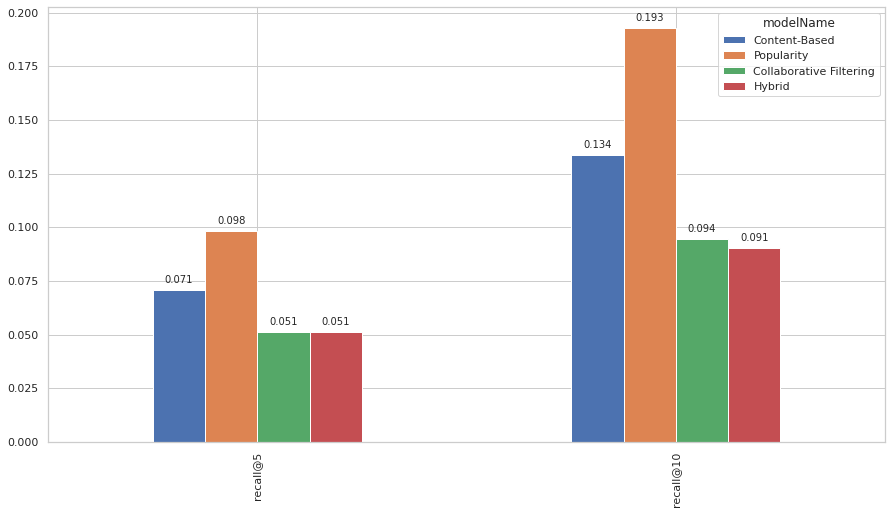

In [54]:
%matplotlib inline
ax = global_metrics_df.transpose().plot(kind='bar', figsize=(15,8))
for p in ax.patches:
    ax.annotate("%.3f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')

# Testing

In [55]:
def inspect_interactions(usr_id, test_set=True):
    if test_set:
        interactions_df = interactions_test_indexed_df
    else:
        interactions_df = interactions_train_indexed_df
    return interactions_df.loc[usr_id].merge(articles_df, how = 'left', 
                                                      left_on = 'contentid', 
                                                      right_on = 'contentid') \
                          .sort_values('eventStrength', ascending = False)[['eventStrength', 
                                                                          'contentid',
                                                                          'head_line', 'link']]

**The recommendations really matches my interests, as I would read all of them!**

In [60]:
hybrid_recommender_model.recommend_items(6, topn=10, verbose=True)

,recStrengthHybrid,contentid,head_line,link
0,71.264496,40061,Jury in George Floyd murder trial shown harrow...,/world/us/jury-in-george-floyd-murder-trial-sh...
1,68.863417,50019,Extortion racket being run under Mamata govt i...,/en/news/extortion-racket-being-run-under-mama...
2,67.152256,30047,"Can't rule out lockdown, says Maha CM as cases...",/city/mumbai/cant-rule-out-lockdown-says-mahar...
3,63.745619,50013,"TMC tried to ban Durga Puja 2yrs ago, now oppo...",/en/news/tmc-tried-to-ban-durga-puja-2yrs-ago-...
4,63.391584,10008,Northern Irish man records one of the highest ...,/en/news/northern-irish-man-records-one-of-the...
5,63.108511,2001,"World was on standstill, you never took a day ...",/en/news/world-was-on-standstill-you-never-too...
6,62.912944,3002,"Mumbai airport imposes ₹1,000 fine for violati...",/en/news/mumbai-airport-imposes-₹1000-fine-for...
7,60.375211,10005,Video of dog stealing Russian reporter's mic v...,/en/news/video-of-dog-stealing-russian-reporte...
8,58.768123,7008,"Tesla delivers 1.84 lakh vehicles in Q1, repor...",/en/news/tesla-delivers-184-lakh-vehicles-in-q...
9,53.623597,20044,Future Retail to offer quick online deliveries...,/business/india-business/future-retail-to-offe...


# summarization 

we thought of compressing the text size of each news article but we got short descriptions thats already summarized. since there are from news, their syntax and semantics are well formated. so we followed upto those descriptions.


In [ ]:
from google.colab import files
fil = files.upload()

In [ ]:
from nltk.corpus import stopwords
from nltk.cluster.util import cosine_distance
import numpy as np
import networkx as nx
 
def read_article(file_name):
    file = open(file_name, "r")
    filedata = file.readlines()
    article = filedata[0].split(". ")
    sentences = []

    for sentence in article:
        print(sentence)
        sentences.append(sentence.replace("[^a-zA-Z]", " ").split(" "))
    sentences.pop() 
    print('no.of total sentences in para: ', len(sentence))

    
    return sentences

def sentence_similarity(sent1, sent2, stopwords=None):
    if stopwords is None:
        stopwords = []
 
    sent1 = [w.lower() for w in sent1]
    sent2 = [w.lower() for w in sent2]
 
    all_words = list(set(sent1 + sent2))
 
    vector1 = [0] * len(all_words)
    vector2 = [0] * len(all_words)
 
    # build the vector for the first sentence
    for w in sent1:
        if w in stopwords:
            continue
        vector1[all_words.index(w)] += 1
 
    # build the vector for the second sentence
    for w in sent2:
        if w in stopwords:
            continue
        vector2[all_words.index(w)] += 1
 
    return 1 - cosine_distance(vector1, vector2)
 
def build_similarity_matrix(sentences, stop_words):
    # Create an empty similarity matrix
    similarity_matrix = np.zeros((len(sentences), len(sentences)))
 
    for idx1 in range(len(sentences)):
        for idx2 in range(len(sentences)):
            if idx1 == idx2: #ignore if both are same sentences
                continue 
            similarity_matrix[idx1][idx2] = sentence_similarity(sentences[idx1], sentences[idx2], stop_words)

    return similarity_matrix


summarize_text = []
def generate_summary(file_name, top_n=5):
    stop_words = stopwords.words('english')

    # Step 1 - Read text anc split it
    sentences =  read_article(file_name)

    # Step 2 - Generate Similary Martix across sentences
    sentence_similarity_martix = build_similarity_matrix(sentences, stop_words)

    # Step 3 - Rank sentences in similarity martix
    sentence_similarity_graph = nx.from_numpy_array(sentence_similarity_martix)
    scores = nx.pagerank(sentence_similarity_graph)

    # Step 4 - Sort the rank and pick top sentences
    ranked_sentence = sorted(((scores[i],s) for i,s in enumerate(sentences)), reverse=True)    
    print("Indexes of top ranked_sentence order are ", ranked_sentence)    

    for i in range(top_n):
      summarize_text.append(" ".join(ranked_sentence[i][1]))

    # Step 5 - Offcourse, output the summarize texr
    print("Summarize Text: \n", ". ".join(summarize_text))
    
    print('summarized to',len(summarize_text), 'sentences')

# let's begin
# generate_summary( "msft.txt", 2)
